# Haystack: Monitoring LLMs for Agents

This guide will guide you on how to use the `ArgillaCallbackHandler` to monitor the LLMs of your Haystack agents and seamlessly log the results into your Argilla Server.

**Haystack** provides powerful tools for constructing and overseeing comprehensive pipelines for LLM production, enabling smooth collaboration with Conversational or RAG models, among others. The seamless integration with Argilla further simplifies the process of monitoring these pipelines. As a result, you gain the flexibility to effortlessly seek human feedback for assessing and optimizing your model's performance.

In this tutorial, we will see two examples where we can benefit from `ArgillaCallbackHandler`. In the first one, we will use a basic conversational agent to answer some questions and logging the answers into Argilla. While the second one is a more advanced version where we will implement tools for our agent.

> Note: Agents are not available in Haystack 2.0. The following examples are based on Haystack 1.x. The integration with Haystack 2.0 will come soon.

## Getting Started

First, we will install the required packages and import the common necessary modules.

In [ ]:
%pip install argilla argilla-haystack['haystack-v1']

In [ ]:
import os
from getpass import getpass

import argilla as rg
from argilla_haystack import ArgillaCallbackHandler

We will also set the `OPENAI_API_KEY` environment variable to use the OpenAI API. You can get your API key from the [OpenAI website](https://openai.com/blog/openai-api).

> Note: Haystack is model agnostic, so you can use any open-source or proprietary model with it. In that case, use the respective API key.

In [4]:
openai_api_key = os.getenv("OPENAI_API_KEY", "sk-...")

### Integrated with Argilla

The `ArgillaCallbackHandler` is a callback handler that logs the results of the agent into the Argilla server. To initialize it, you can add the following arguments:

* `agent`: The agent we will create and want to monitor.
* `dataset_name`: The name of the dataset in the Argilla Server, where it will log in the results.
* `workspace_name`: The name of the workspace in the Argilla Server, where the dataset is located. Defaults to the current workspace.
* `api_url`: The URL of the Argilla Server. Defaults to **http://localhost:6900**.
* `api_key`: The API key of the Argilla Server. Defaults to **argilla.apikey**.
* `questions`: A list of questions that will be asked to the annotators. If not provided, it will use the default questions: `response-rating` and `response-feedback`.
* `guidelines`: The guidelines that will be shown to the annotators. If not provided, it will use the default guidelines.

If there is an existing dataset with the given name and the supported fields, it will use it. Otherwise, it will create a new one with the fields `prompt`, `response`, and `time-details` (duration of each agent and tool execution), and optionally the `transcript` (the process followed to get the final answer) when tools are added. Additionally, it will have the default or provided guidelines and questions. For more information, see [how to format the guidelines and questions](/practical_guides/create_update_dataset/create_dataset.html).

To learn more about connecting to the Argilla Server, check the [Argilla documentation](getting_started/installation/deployments/deployments.html).

## Conversational Agent

To use `ArgillaCallbackHandler` within your Haystack workflow, you first need to create an **agent**. For this tutorial, we will use a basic conversational agent without tools that will be able to answer questions.

The code snippet below will create a simple `ConversationalAgent` using Haystack. The agent will take the `PromptNode`, which defines the LLM and the NLP task, and the `ConversationSummaryMemory`, which is used to store the conversation history and periodically generates summaries. For more information, check the [Haystack documentation](https://docs.haystack.deepset.ai/docs/agent).

In [ ]:
from haystack.nodes import PromptNode
from haystack.agents.memory import ConversationSummaryMemory
from haystack.agents.conversational import ConversationalAgent

# Define the prompt node
prompt_node = PromptNode(
    model_name_or_path="gpt-3.5-turbo-instruct", api_key=openai_api_key, max_length=256, stop_words=["Human"]
)

# Define the memory
summary_memory = ConversationSummaryMemory(prompt_node)

# Define the conversational agent
conversational_agent = ConversationalAgent(prompt_node=prompt_node, memory=summary_memory)

Now that we have an up and running agent, we can employ the `ArgillaCallbackHandler`.

In [ ]:
# Initialize the argilla callback handler
dataset_name = "conversational_ai"
api_url = "http://localhost:6900/"
api_key = "argilla.apikey"

argilla_callback = ArgillaCallbackHandler(agent=conversational_agent, dataset_name=dataset_name)

With the agent defined and the callback initialized, we are now ready to monitor our agent and log into Argilla. Let us run the agent.

In [19]:
# Define some example queries
queries = [
    "Tell me the three most interesting things about Istanbul, Turkey",
    "What is the capital of Turkey?"
    ]

In [ ]:
for query in queries:
    conversational_agent.run(query)

As seen, the agent responded to the query and gave us the response. The records have also been updated to the Argilla Server. Let us check it on the Argilla Server.


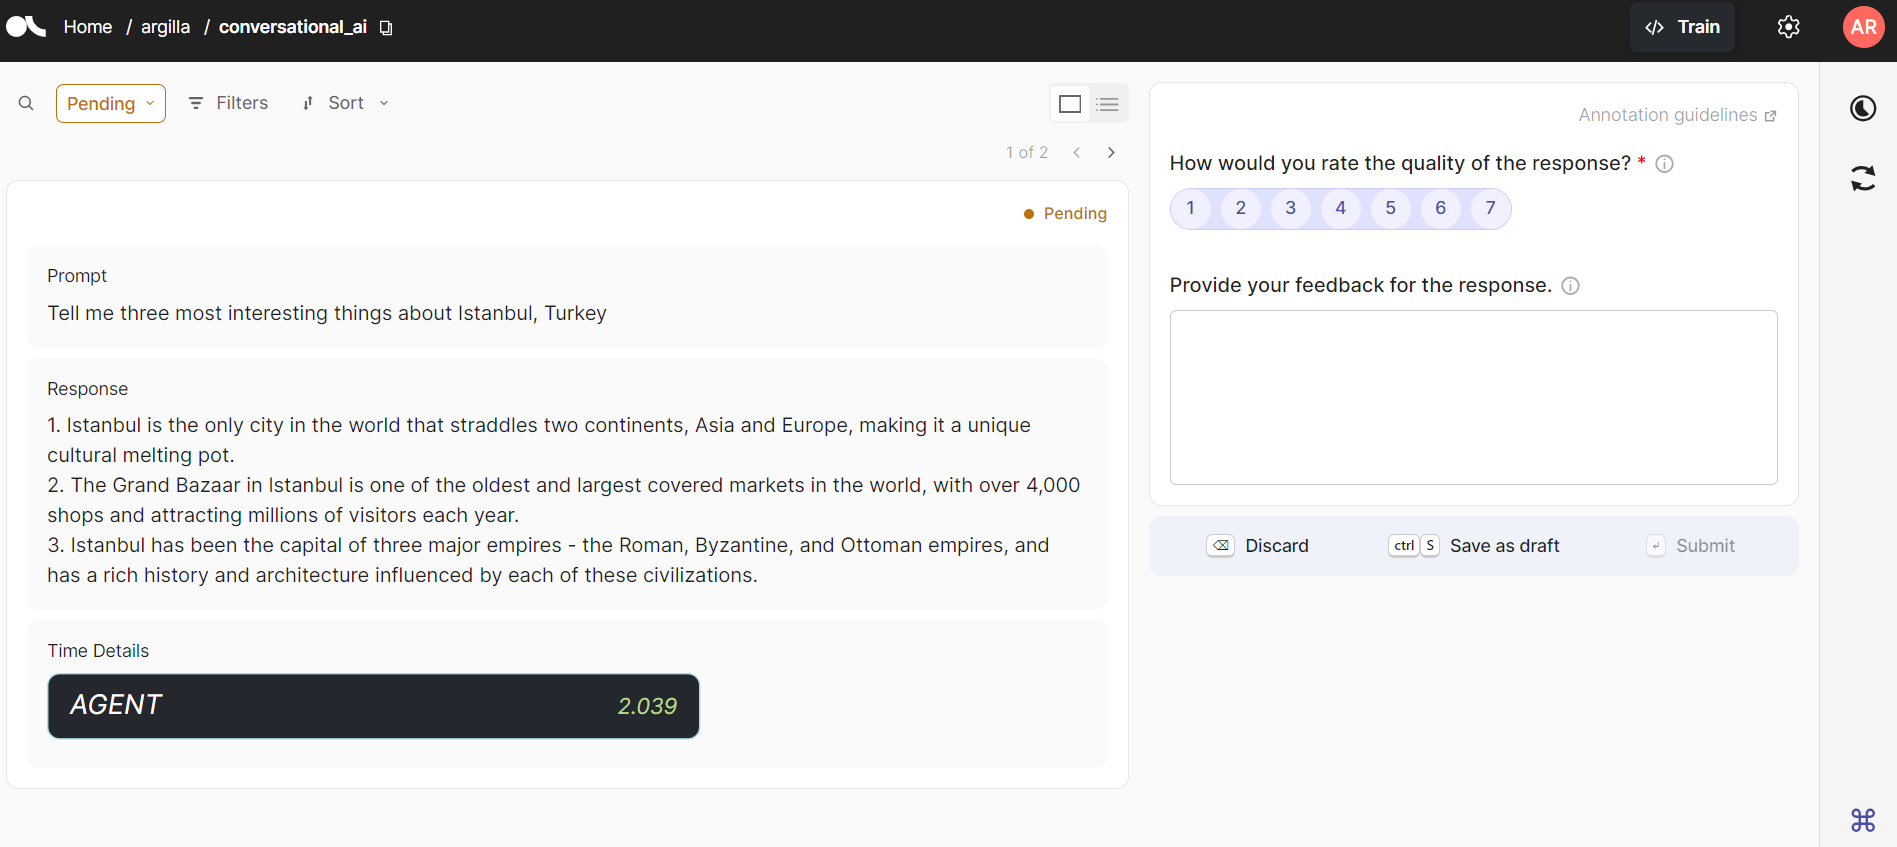

## Conversational Agent with Tools

If you would like to employ your agent in a more advanced workflow, you can turn it to a decision-maker, where it determines the best course of action in a given situation. Haystack agents makes use of various Tools or Memory components to achieve a good performance where the task requires versatile LLM skills and each specific subtask needs to be handled differently. This tutorial is a modified version from the [Haystack documentation](https://haystack.deepset.ai/tutorials/25_customizing_agent) and you can find more tutorials and examples there.

So, first, let's import the necessary modules.

In [21]:
from datasets import load_dataset

from haystack.document_stores import InMemoryDocumentStore
from haystack.nodes import PromptNode, PromptTemplate, AnswerParser, BM25Retriever
from haystack.pipelines import Pipeline

from haystack.agents import Tool
from haystack.agents.memory import ConversationSummaryMemory
from haystack.agents.base import Agent, ToolsManager

The main difference is that we will use two tools to answer our questions: one to generate responses regarding the Seven Wonders of the World and another to respond about animals. This way each tool is specialized in a specific topic and we will be able to showcase how the agent will choose the best tool to answer the question. In this case, both pipelines are of the same type, but they could be [different](https://docs.haystack.deepset.ai/docs/agent#tools).

In [ ]:
# Download the datasets required for the example
dataset_wonders = load_dataset("bilgeyucel/seven-wonders", split="train")
dataset_animals = load_dataset("atmallen/animals_azaria_mitchell", split="test")

In [24]:
# The document store will store the data of the 'content' column
dataset_animals = dataset_animals.rename_column("statement", "content")

Then, let us create the generative pipelines that our agent will be using as Tools.

In [ ]:
# Define the first pipeline and its components

# Save the information in the document store and define the retriever
document_store_wonders = InMemoryDocumentStore(use_bm25=True)
document_store_wonders.write_documents(dataset_wonders)
retriever_wonders = BM25Retriever(document_store=document_store_wonders)

# Define the prompt node with a custom prompt template
prompt_wonders = "Please use a maximum of 50 tokens. Question: {query}\nDocuments: {join(documents)}\nAnswer:"
prompt_template_wonders = PromptTemplate(
    prompt=prompt_wonders,
    output_parser=AnswerParser(),
)
prompt_node_wonders = PromptNode(
    model_name_or_path="gpt-3.5-turbo-instruct", api_key=openai_api_key, default_prompt_template=prompt_template_wonders
)

# Define the generative pipeline
generative_pipeline_wonders = Pipeline()
generative_pipeline_wonders.add_node(component=retriever_wonders, name="Retriever", inputs=["Query"])
generative_pipeline_wonders.add_node(component=prompt_node_wonders, name="Prompt", inputs=["Retriever"])

In [ ]:
# Define the second pipeline and its components

# Save the information in the document store and define the retriever
document_store_animals = InMemoryDocumentStore(use_bm25=True)
document_store_animals.write_documents(dataset_animals)
retriever_animals = BM25Retriever(document_store=document_store_animals)

# Define the prompt node with a custom prompt template
prompt_animals = "Please use a maximum of 50 tokens. Question: {query}\nDocuments: {join(documents)}\nAnswer:"
prompt_template_animals = PromptTemplate(
    prompt=prompt_animals,
    output_parser=AnswerParser(),
)
prompt_node_animals = PromptNode(
    model_name_or_path="gpt-3.5-turbo-instruct", api_key=openai_api_key, default_prompt_template=prompt_template_animals
)

# Define the generative pipeline
generative_pipeline_animals = Pipeline()
generative_pipeline_animals.add_node(component=retriever_animals, name="Retriever", inputs=["Query"])
generative_pipeline_animals.add_node(component=prompt_node_animals, name="Prompt", inputs=["Retriever"])

Now, we will define both tools that our agent will use to answer the questions. We will indicate their name, the defined pipelines, the description used to select it and the output name.

In [31]:
# Tool for wonders
search_tool_wonders = Tool(
    name="Search_tool_wonders",
    pipeline_or_node=generative_pipeline_wonders,
    description="useful for when you need to answer questions about the seven wonders of the world",
    output_variable="answers",
)

# Tool for animals
search_tool_animals = Tool(
    name="Search_tool_animals",
    pipeline_or_node=generative_pipeline_animals,
    description="useful for when you need to answer questions about animals",
    output_variable="answers",
)

As we did in the previous example, we need to define some elements for our agent.

In [32]:
# Define the prompt node
agent_prompt_node = PromptNode(
    "gpt-3.5-turbo",
    api_key=openai_api_key,
    max_length=256,
    stop_words=["Observation:"],
    model_kwargs={"temperature": 0.5},
)

# Define the memory
memory_prompt_node = PromptNode(
    model_name_or_path="philschmid/bart-large-cnn-samsum", max_length=256, model_kwargs={"task_name":"text2text-generation"} 
)
memory = ConversationSummaryMemory(
    prompt_node=memory_prompt_node, prompt_template="{chat_transcript}"
)

We will need a prompt which will be used to query the tool by the agent. It should be sufficiently detailed to obtain a good response from the agent.

In [33]:
agent_prompt = """
In the following conversation, a human user interacts with an AI Agent. The human user poses questions, and the AI Agent goes through several steps to provide well-informed answers.
The AI Agent must use the available tools to find the up-to-date information. The final answer to the question should be truthfully based solely on the output of the tools. The AI Agent should ignore its knowledge when answering the questions.
The AI Agent has access to these tools:
{tool_names_with_descriptions}

The following is the previous conversation between a human and The AI Agent:
{memory}

AI Agent responses must start with one of the following:

Thought: [the AI Agent's reasoning process]
Tool: [tool names] (on a new line) Tool Input: [input as a question for the selected tool WITHOUT quotation marks and on a new line] (These must always be provided together and on separate lines.)
Observation: [tool's result]
Final Answer: [final answer to the human user's question]

When selecting a tool, the AI Agent must provide both the "Tool:" and "Tool Input:" pair in the same response, but on separate lines.

The AI Agent should not ask the human user for additional information, clarification, or context.
If the AI Agent cannot find a specific answer, it should accept the first word of the answer it found as the answer to the query.

Question: {query}
Thought:
{transcript}
"""

As the last step before creating the agent, we need a resolver function that will handle the prompt given.

In [34]:
def resolver_function(query, agent, agent_step):
    return {
        "query": query,
        "tool_names_with_descriptions": agent.tm.get_tool_names_with_descriptions(),
        "transcript": agent_step.transcript,
        "memory": agent.memory.load(),
    }

We are now ready to define the agent with the given pipeline, prompt and tools.

In [38]:
conversational_agent_search = Agent(
    agent_prompt_node,
    prompt_template=agent_prompt,
    prompt_parameters_resolver=resolver_function,
    memory=memory,
    tools_manager=ToolsManager([search_tool_wonders, search_tool_animals]),
)

After getting the agent ready, we will be initializing the `ArgillaCallback` as we did in the previous example. Check the [initial section](#integrated-with-argilla) if you prefer further customization.

In [ ]:
api_key = "argilla.apikey"
api_url = "http://localhost:6900/"
dataset_name = "search_the_documents"

argilla_callback = ArgillaCallbackHandler(agent=conversational_agent_search, dataset_name=dataset_name, api_url=api_url, api_key=api_key)

Finally, we can run the agent and see the results. Note that with our questions, it will choose the best tool to answer it or ask for human feedback if it is not confident enough.

In [40]:
# Define some example queries
queries =[
    "Where is the temple of Artemis?",
    "What does a kangaroo eat?",
    "Where can I go?"
    ]

In [ ]:
for query in queries:
    conversational_agent_search.run(query)

As well as giving the response to the user, the agent has also logged the results into the Argilla Server. In this case the transcript with the internal monologue of the agent was also added to our dataset.

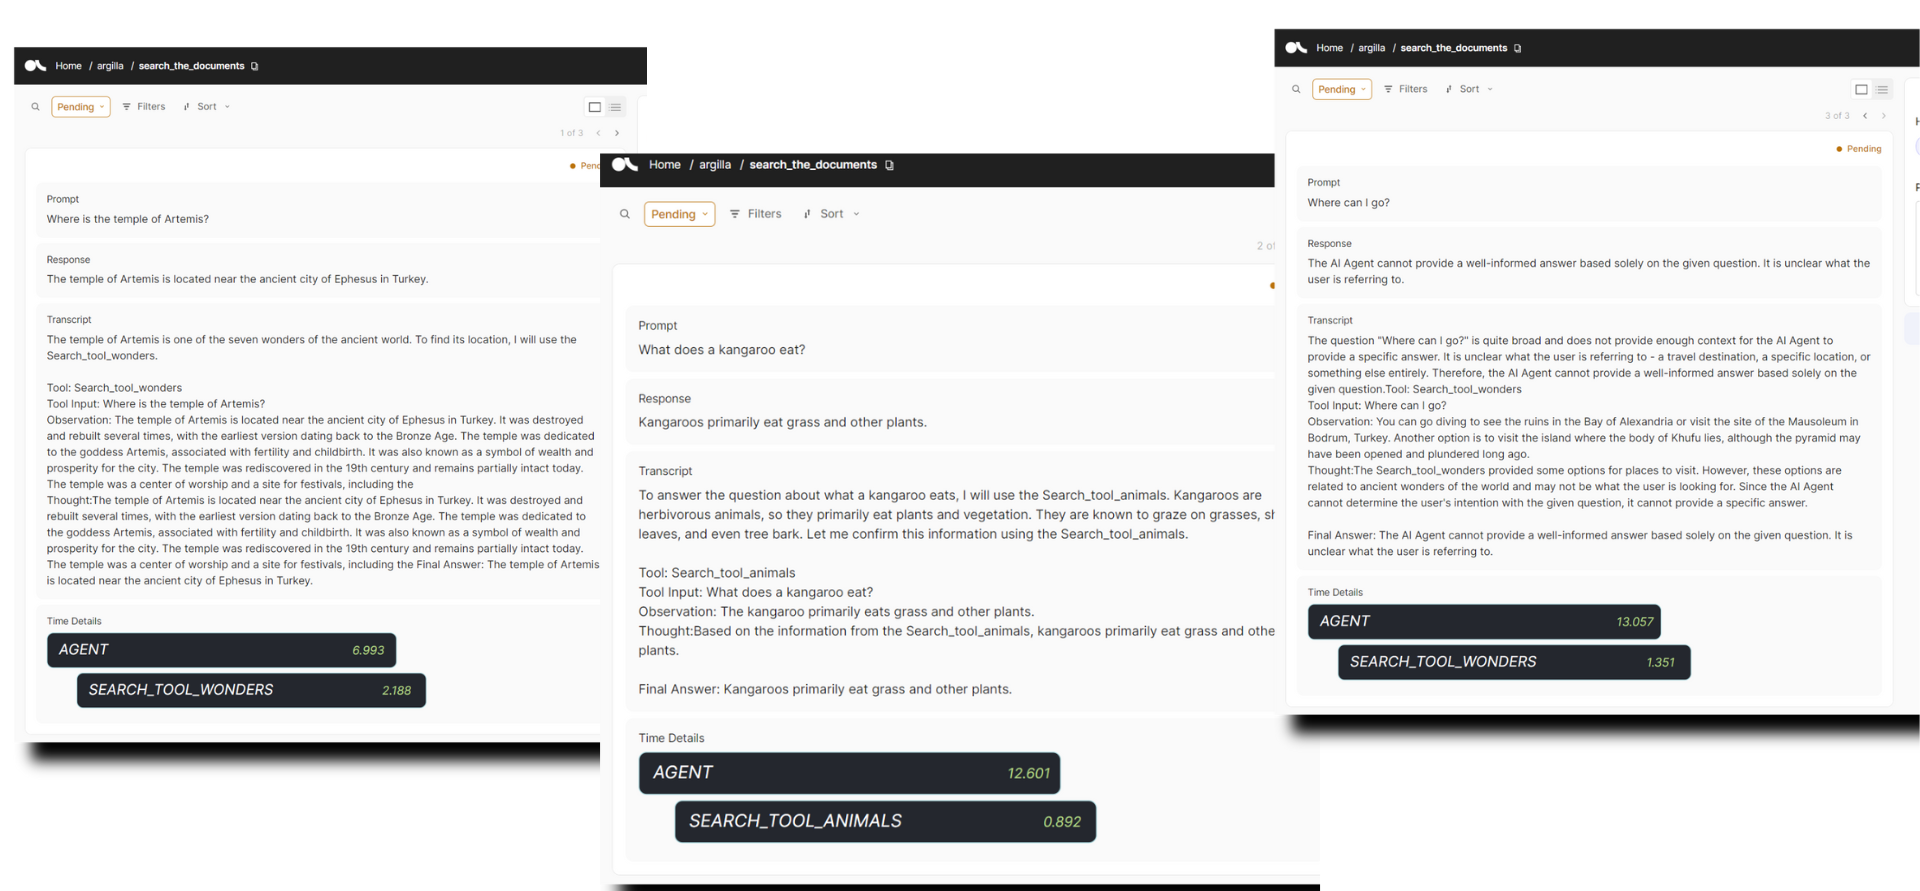

`ArgillaCallbackHandler` has also logged the name of the tool used and its type as `metadata`. Let us see the metadata of the record.

In [42]:
dataset = rg.FeedbackDataset.from_argilla(dataset_name)
dataset[0].metadata

{'tool_name': ['Search_tool_wonders'], 'type': 'generative'}

## Conclusions

This guide has shown us the process of utilizing the ArgillaCallbackHandler to keep track of your Haystack agents' LLMs and effortlessly record the outcomes in your Argilla Server. Additionally, we've explored two instances demonstrating the advantages of using ArgillaCallbackHandler. The first instance involved employing a simple conversational agent to respond to queries, with the responses being recorded in Argilla. In the second scenario, we introduced tools for our agent and observed how it selects the most appropriate tool for answering a question or seeks human input when it lacks confidence.

For more information, on other integrations check the tutorials [here](/tutorials_and_integrations/integrations/integrations.html). The integration for Haysack 2.0 will come soon.